# Heterogeneous transfer learning for highly non-linear regression tasks: data sets simulation and analysis

This notebook shows how to simulate data sets and generate the target overlapping matrix (common samples between data sets). It also demonstrates an example of the tire inhibition effect when increasing temperature, using fixed features and common parameters shared across domains. Note: Source and target kinetic parameters required for simulation are not provided for confidentiality.

In [ ]:
import pandas as pd
import os, sys
import numpy as np
import seaborn as sns
import warnings
import glob

import os
import sys

# Get the current working directory (where the notebook is)
current_dir = os.getcwd()

# Add the parent directory to sys.path (where hck_tools and python_files are)
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)

from python_files.Simulation_functions import * # contain the function that simulate the data sets
from python_files.Plot_functions import *
from python_files.utils import *

# Example of parameters bounds used to contraint the parameters space (HBTL, L-BFGS-B, etc.) -> The one used in the papers results are not provided for confidentiality
# Note: The bounds are not actually used in the ODE solving process - they are only 
# included because our proprietary solver requires them in the DataFrame format.
# The simulation simply uses the parameter values ('param init') to solve the ODE system.
params_bounds_source = [(0, 1e3), (10000, 80000), (0.3, 10), (0.3, 10), (-10, 0), 
                        (-40000, 0), (0, 10), (-5, 5), (0, 3), (-10, 10), (-10, 10)]

params_bounds_target = [(0, 1e3), (10000, 80000), (0.3, 10), (0.3, 10), (-10, 0), 
                        (-40000, 0), (0, 10), (-5, 5), (0, 3), (-10, 10), (-10, 10), 
                        (0, 10)]

# Parameters of source and target used for the simulation 

In [ ]:
# Example of source (fossil) kinetic parameters 
# Note: The parameters used in the paper's results are not provided for confidentiality.
# The parameters given below may not successfully simulate data sets, as they are not 
# physically realistic - they are provided for illustration purposes only.
params_source = [1e6, 60000, 5.35, 7.2, -8.5, -35253, 6.21, -4.276, 1.29, 5.38, -2.25]
params_source_df = params_transform(params_source, nte=False, bounds=params_bounds_source)

# Simulation parameters (target model) -> Adding 20% for the source parameters and then setting p equal to A0
params_target = 1.2 * params_source 
params_target = params_target + params_target[6]
params_target_df = params_transform(params_target, nte=True, bounds=params_bounds_target)

## Source and target simulation

One source data set containing 10,000 points with 8 points per feed is simulated, while 20 target data sets with 5 points per feed are simulated.

Uniform noise of 20% is added to the output to represent measurement uncertainty.

In [ ]:
source = Simulation_multiple_ks_opt(n_data=1, params=params_source_df, nb_pt=10000, nb_pt_feed=8, 
                                    delta_var = [10, 0.25, 10, 0.75 ,150, 0.5, 20, 2.25], noise_per=0.15,
                                    nte=False)
source = source[0] # the function return a list of the total simulated data sets, here only one was simulated

In [ ]:
target = Simulation_multiple_ks_opt(n_data=20, params=params_target_df, nb_pt=10020, nb_pt_feed=5, 
                                    delta_var = [10, 0.25, 10, 0.75 ,150, 0.5, 20, 2.25], noise_per=0.15,
                                    nte=True)

## Saving the data sets

In [ ]:
# Saving the simulated data sets

#source
source.to_csv("Simulated_datasets/source_10000.csv")

# target
for i in range(20):
    target[i].to_csv("Simulated_datasets/Target_data_sets/target_base" + str(i) + ".csv")

## Example of $Tire$ inhibition impact

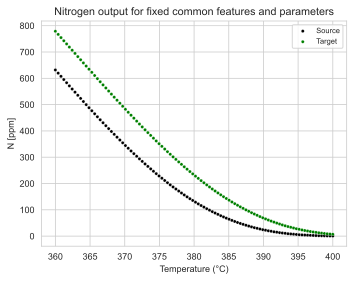

In [ ]:
# Generate multiple temperature values
Temperature = np.linspace(360, 400, 100)

# Create a source (fossil) dataset with varying temperature and fixed other features.
data_fossil = {
    "Feed_name": ["Feed_0"] * len(Temperature),  
    "T": list(Temperature),
    "ppH2": [150] * len(Temperature),
    "LHSV": [2] * len(Temperature),
    "Res0": [6] * len(Temperature),
    "N0": [2000] * len(Temperature),  
    "S0": [1.2] * len(Temperature),   
    "TMP": [450] * len(Temperature),
}
data_fossil = pd.DataFrame(data_fossil)
data_fossil = output_data(data_fossil, params_source_df, nte=False, bounds=params_bounds_source) # Returns the complete dataset with the simulated nitrogen output (N_simul column).

# Create a target (NTE) dataset in the same manner.
data_nte = {
    "Feed_name": ["Feed_0"] * len(Temperature),  
    "T": list(Temperature),
    "ppH2": [150] * len(Temperature),
    "LHSV": [2] * len(Temperature),
    "Res0": [6] * len(Temperature),
    "N0": [2000] * len(Temperature),   
    "S0": [1.2] * len(Temperature),
    "TMP": [450] * len(Temperature),
    "Tire":[3 for i in range(len(Temperature))] # Tire is the tire component in the feedstock
    }
data_nte= pd.DataFrame(data_nte)
data_nte = output_data(data_nte, params_target_df, nte=True) 

sns.set_style("whitegrid")
plt.figure(figsize=(5, 4))
sns.scatterplot(data_fossil["T"], data_fossil["N_simul"], color="black", label="Source", s=10)
sns.scatterplot(data_nte["T"], data_nte["N_simul"], color="green", label="Target", s=10)

plt.xlabel("Temperatureerature (°C)")
plt.ylabel("N [ppm]")
plt.title("Nitrogen output for fixed common features and parameters")
plt.legend()
plt.tight_layout()

plt.savefig("Saved_figures/N_T_source_target.pdf", bbox_inches="tight")

plt.show()

## Overlapping Matrix for the target data sets

The matrix of overlapping points highlights the diversity of our simulation strategy.

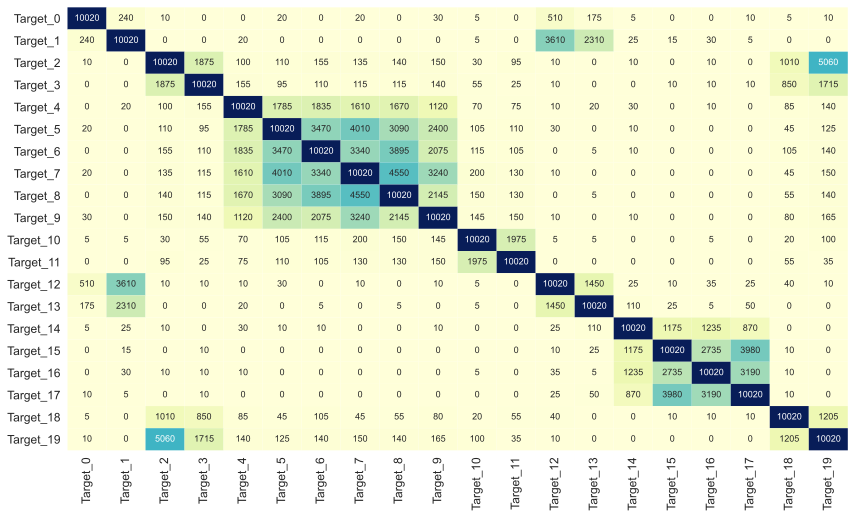

In [7]:
path_target = "Simulated_datasets/Target_data_sets"
target_files = glob.glob(os.path.join(path_target, "*.csv"))

# Create dictionaries mapping dataset names to file paths
target_files_dict = {f"Target_{i}": path for i, path in enumerate(target_files)}

# Compute overlap matrix for target datasets
target_overlap_matrix = compute_overlap_matrix(target_files_dict)

# Disable LaTeX rendering in Matplotlib
plt.rcParams["text.usetex"] = False

# Rename the index and columns with plain text names
target_overlap_matrix_ = target_overlap_matrix
target_overlap_matrix_.index = [f"Target_{i}" for i in range(len(target_overlap_matrix))]
target_overlap_matrix_.columns = [f"Target_{i}" for i in range(len(target_overlap_matrix))]

# Plot the heatmap with updated labels
plt.figure(figsize=(14, 8))
ax = sns.heatmap(target_overlap_matrix, annot=True, cmap='YlGnBu', fmt="0.0f", cbar=False)  # Remove the color bar

# Ensure the new labels are properly displayed
ax.set_xticklabels(target_overlap_matrix_.columns, rotation=90, fontsize=12)
ax.set_yticklabels(target_overlap_matrix_.index, fontsize=12)

# Save the figure
plt.savefig("Saved_figures/target_overlap.pdf", dpi=300)
plt.show()